In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
import TSManager as ts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

from CorrScreen import CorrScreenPredictor
import TSManager as ts
from TradingBot import TradingBot

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
reload(ts)
mgr = ts.TSManager()
mgr.load()
df = mgr.data
#df = pd.read_pickle('train_prepared.pkl')
df.head()

Loading DP
Loading PE
Loading BM
Loading CAPE
Loading BY
Loading DEF
Loading PCAPrice
Loading CPI
Loading NOS
Loading PCR
Loading OIL
Loading SI
Loading BDI
Loading CAY
Loading IC
Loading TERM
Loading VRP
Loading SPX
Loading MA
Loading SIM
Loading RF


,DP,PE,BM,CAPE,BY,DEF,PCAPrice,CPI,NOS,PCR,...,SI,BDI,CAY,IC,TERM,VRP,SPX,MA,SIM,RF
AsOfDate,,,,,,,,,,,,,,,,,,,,,
1990-06-08,0.063979,7.524271,NaN,8.978524,1.007418,0.96,3.616905,0.046737,0.016941,-1.622923,...,NaN,1278.0,-0.013576,NaN,0.50,7.197727,-0.012302,1,0.715385,NaN
1990-06-11,0.063463,7.597792,NaN,9.051612,1.009642,0.96,3.583706,0.046737,0.016941,-1.615366,...,NaN,1264.0,-0.013576,NaN,0.49,5.607431,0.008107,1,0.707692,NaN
1990-06-12,0.062662,7.699009,NaN,9.167251,1.009580,0.96,3.532720,0.046737,0.016941,-1.618868,...,NaN,1254.0,-0.013576,NaN,0.49,6.403252,0.012695,1,0.700000,NaN
1990-06-13,0.062894,7.674771,NaN,9.133460,1.000056,0.96,3.547245,0.046737,0.016941,-1.625316,...,NaN,1243.0,-0.013576,NaN,0.47,7.793147,-0.003693,1,0.692308,NaN
1990-06-14,0.063241,7.636994,NaN,9.083400,0.997689,0.96,3.569002,0.046737,0.016941,-1.620454,...,NaN,1232.0,-0.013576,NaN,0.46,7.665179,-0.005496,1,0.684615,NaN


In [3]:
# constructing the target label
df['spx_tp130'] = df['SPX'].rolling(130).sum().shift(-129)
df = df.dropna(subset=['spx_tp130'])

In [4]:
# normalization pipeline
scaler = StandardScaler()
si = SimpleImputer(strategy='median')
pipe = make_pipeline(scaler, si)

In [5]:
cols_to_pipe = [c for c in df.columns if c not in ['SPX','RF','spx_tp130']]
df[cols_to_pipe] = pipe.fit_transform(df[cols_to_pipe])

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


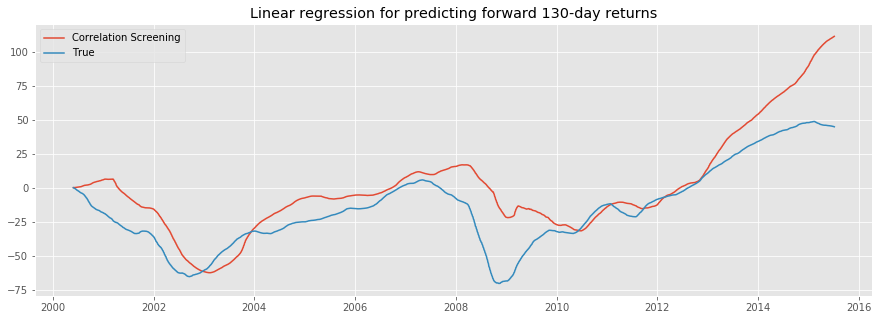

In [6]:
# test predictions

nbp = 190 # number of periods to be used
CSP = CorrScreenPredictor(df)
CSP.plot_predict(nbp)

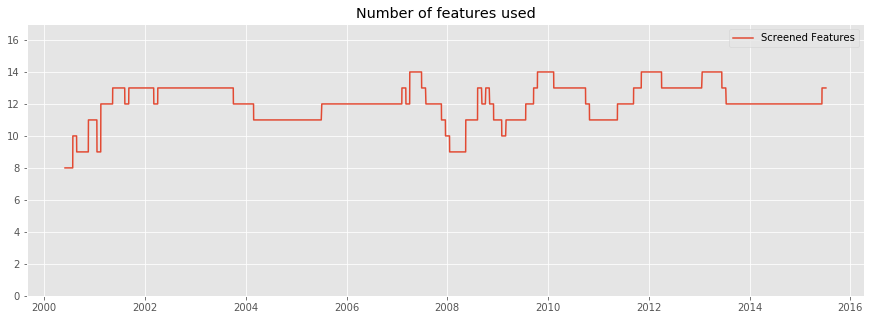

In [7]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

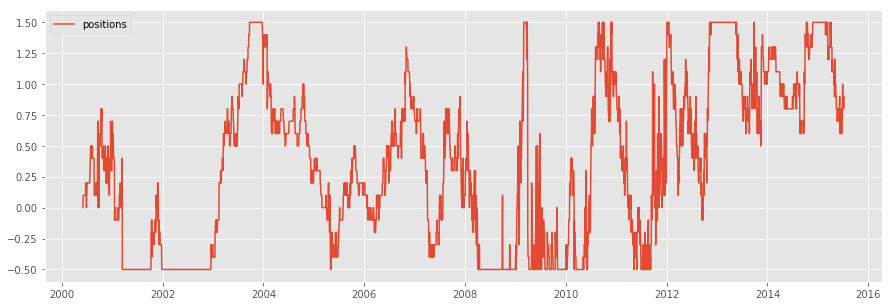

In [8]:
# plot positions

tb = TradingBot(df)

pos = tb.CS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

------------------------------
number of years    : 15.08
annual return SPX  : 3.22 %
annual return strat: 4.87 %
------------------------------


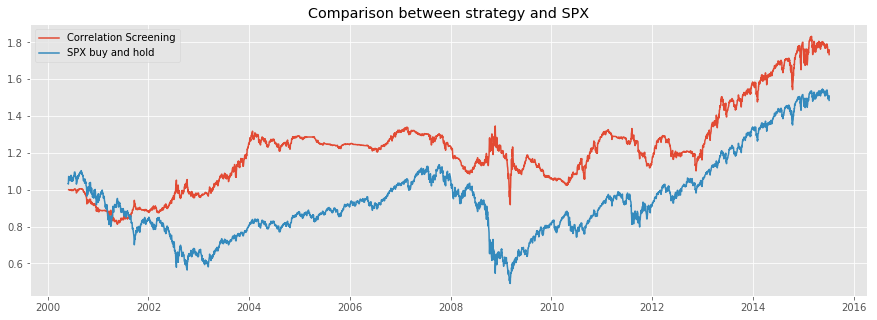

In [9]:
# plot wealth

tb.plot_wealth_CS(nbp)